# Coverage of MultiPLIER LV

The goal of this notebook is to examine why genes were found to be generic. Specifically, this notebook is trying to answer the question: Are generic genes found in more multiplier latent variables compared to specific genes?

The PLIER model performs a matrix factorization of gene expression data to get two matrices: loadings (Z) and latent matrix (B). The loadings (Z) are constrained to aligned with curated pathways and gene sets specified by prior knowledge [Figure 1B of Taroni et. al.](https://www.cell.com/cell-systems/pdfExtended/S2405-4712(19)30119-X). This ensure that some but not all latent variables capture known biology. The way PLIER does this is by applying a penalty such that the individual latent variables represent a few gene sets in order to make the latent variables more interpretable. Ideally there would be one latent variable associated with one gene set unambiguously.

While the PLIER model was trained on specific datasets, MultiPLIER extended this approach to all of recount2, where the latent variables should correspond to specific pathways or gene sets of interest. Therefore, we will look at the coverage of generic genes versus other genes across these MultiPLIER latent variables, which represent biological patterns.

**Definitions:**
* Generic genes: Are genes that are consistently differentially expressed across multiple simulated experiments.

* Other genes: These are all other non-generic genes. These genes include those that are not consistently differentially expressed across simulated experiments - i.e. the genes are specifically changed in an experiment. It could also indicate genes that are consistently unchanged (i.e. housekeeping genes)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import textwrap
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

from ponyo import utils
from generic_expression_patterns_modules import lv

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Get data directory containing gene summary data
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))
data_dir = os.path.join(base_dir, "pseudomonas_analysis")

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_pseudomonas_33245.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]

project_id = params["project_id"]
quantile_threshold = 0.97

In [3]:
# Output file
nonzero_figure_filename = "nonzero_LV_coverage_multiPLIER_pa.svg"
highweight_figure_filename = "highweight_LV_coverage_multiPLIER_pa.svg"

## Load data

In [4]:
# Get gene summary file
summary_data_filename = os.path.join(
    data_dir, f"generic_gene_summary_{project_id}_cbrB_v_WT.tsv"
)

In [5]:
# Load gene summary data
data = pd.read_csv(summary_data_filename, sep="\t", index_col=0, header=0)

# Check that genes are unique since we will be using them as dictionary keys below
assert data.shape[0] == len(data["Gene ID"].unique())

In [6]:
# Load multiplier models
# Converted formatted pickle files (loaded using phenoplier environment) from
# https://github.com/greenelab/phenoplier/blob/master/nbs/01_preprocessing/005-multiplier_recount2_models.ipynb
# into .tsv files
multiplier_model_z = pd.read_csv(
    "multiplier_Pa_model_z.tsv", sep="\t", index_col=0, header=0
)

In [7]:
# Get a rough sense for how many genes contribute to a given LV
# (i.e. how many genes have a value != 0 for a given LV)
# Notice that multiPLIER is a sparse model
(multiplier_model_z != 0).sum().sort_values(ascending=True)

LV13    1844
LV14    1868
LV17    1925
LV7     1943
LV1     1970
LV5     2035
LV2     2042
LV9     2053
LV11    2119
LV31    2130
LV23    2141
LV71    2180
LV39    2186
LV33    2193
LV56    2204
LV38    2213
LV24    2225
LV58    2232
LV44    2262
LV16    2276
LV6     2281
LV69    2296
LV30    2309
LV55    2321
LV32    2322
LV52    2332
LV18    2351
LV43    2352
LV21    2355
LV68    2372
        ... 
LV3     2498
LV53    2504
LV4     2506
LV41    2506
LV15    2516
LV47    2539
LV42    2576
LV19    2579
LV10    2580
LV26    2586
LV37    2611
LV57    2614
LV61    2626
LV49    2650
LV40    2652
LV12    2659
LV62    2684
LV28    2728
LV50    2734
LV8     2748
LV67    2758
LV72    2761
LV34    2766
LV54    2778
LV35    2781
LV48    2785
LV60    2796
LV64    2888
LV63    2903
LV59    2917
Length: 72, dtype: int64

## Get gene data

Define generic genes based on simulated gene ranking. Refer to [figure](https://github.com/greenelab/generic-expression-patterns/blob/master/pseudomonas_analysis/gene_ranking_logFC.svg) as a guide.

**Definitions:**
* Generic genes: `Percentile (simulated) >= 80`

(Having a high rank indicates that these genes are consistently changed across simulated experiments.)

* Other genes: `Percentile (simulated) < 80`

(Having a lower rank indicates that these genes are not consistently changed across simulated experiments - i.e. the genes are specifically changed in an experiment. It could also indicate genes that are consistently unchanged.)

In [8]:
generic_threshold = 80
dict_genes = lv.get_generic_specific_genes(data, generic_threshold)

(5549, 14)
No. of generic genes: 1110
No. of other genes: 4439


In [9]:
# Check overlap between multiplier genes and our genes
multiplier_genes = list(multiplier_model_z.index)
our_genes = list(data.index)
shared_genes = set(our_genes).intersection(multiplier_genes)

print(len(our_genes))
print(len(shared_genes))

5549
5549


In [10]:
# Drop gene ids not used in multiplier analysis
processed_dict_genes = lv.process_generic_specific_gene_lists(
    dict_genes, multiplier_model_z
)

In [11]:
# Check numbers add up
assert len(shared_genes) == len(processed_dict_genes["generic"]) + len(
    processed_dict_genes["other"]
)

## Get coverage of LVs

For each gene (generic or other) we want to find:
1. The number of LVs that gene is present
2. The number of LVs that the gene contributes a lot to (i.e. the gene is highly weighted within that LV)

### Nonzero LV coverage

In [12]:
dict_nonzero_coverage = lv.get_nonzero_LV_coverage(
    processed_dict_genes, multiplier_model_z
)

In [13]:
# Check genes mapped correctly
assert processed_dict_genes["generic"][0] in dict_nonzero_coverage["generic"].index
assert len(dict_nonzero_coverage["generic"]) == len(processed_dict_genes["generic"])
assert len(dict_nonzero_coverage["other"]) == len(processed_dict_genes["other"])

### High weight LV coverage

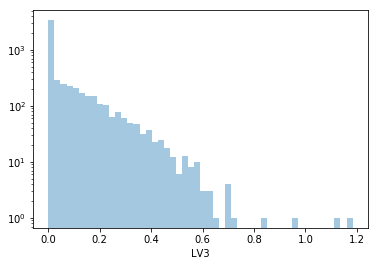

In [14]:
# Quick look at the distribution of gene weights per LV
sns.distplot(multiplier_model_z["LV3"], kde=False)
plt.yscale("log")

In [15]:
dict_highweight_coverage = lv.get_highweight_LV_coverage(
    processed_dict_genes, multiplier_model_z, quantile_threshold
)

In [16]:
# Check genes mapped correctly
assert processed_dict_genes["generic"][0] in dict_highweight_coverage["generic"].index
assert len(dict_highweight_coverage["generic"]) == len(processed_dict_genes["generic"])
assert len(dict_highweight_coverage["other"]) == len(processed_dict_genes["other"])

### Assemble LV coverage and plot

In [17]:
all_coverage = []
for gene_label in dict_genes.keys():
    merged_df = pd.DataFrame(
        dict_nonzero_coverage[gene_label], columns=["nonzero LV coverage"]
    ).merge(
        pd.DataFrame(
            dict_highweight_coverage[gene_label], columns=["highweight LV coverage"]
        ),
        left_index=True,
        right_index=True,
    )
    merged_df["gene type"] = gene_label
    all_coverage.append(merged_df)

all_coverage_df = pd.concat(all_coverage)

In [18]:
all_coverage_df = lv.assemble_coverage_df(
    processed_dict_genes, dict_nonzero_coverage, dict_highweight_coverage
)
all_coverage_df.head()

,nonzero LV coverage,highweight LV coverage,gene type
PA1404,34,2,generic
PA3486,29,5,generic
PA3592,27,0,generic
PA0737,35,3,generic
PA4764,24,3,generic


Text(0.5, 1.0, 'Number of LVs genes are present in')

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


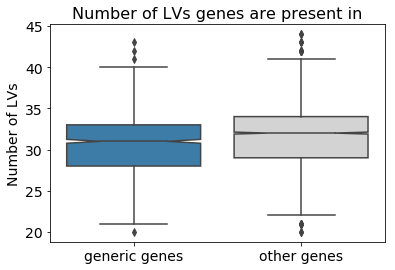

In [19]:
# Plot coverage distribution given list of generic coverage, specific coverage
nonzero_fig = sns.boxplot(
    data=all_coverage_df,
    x="gene type",
    y="nonzero LV coverage",
    notch=True,
    palette=["#2c7fb8", "lightgrey"],
)
nonzero_fig.set_xlabel(None)
nonzero_fig.set_xticklabels(
    ["generic genes", "other genes"], fontsize=14, fontname="Verdana"
)
nonzero_fig.set_ylabel(
    textwrap.fill("Number of LVs", width=30), fontsize=14, fontname="Verdana"
)
nonzero_fig.tick_params(labelsize=14)
nonzero_fig.set_title(
    "Number of LVs genes are present in", fontsize=16, fontname="Verdana"
)

Text(0.5, 1.0, 'Number of LVs genes contribute highly to')

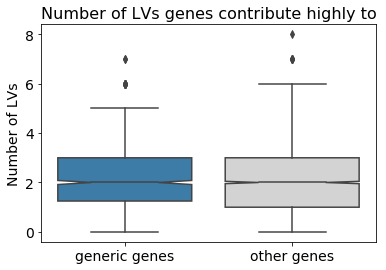

In [20]:
# Plot coverage distribution given list of generic coverage, specific coverage
highweight_fig = sns.boxplot(
    data=all_coverage_df,
    x="gene type",
    y="highweight LV coverage",
    notch=True,
    palette=["#2c7fb8", "lightgrey"],
)
highweight_fig.set_xlabel(None)
highweight_fig.set_xticklabels(
    ["generic genes", "other genes"], fontsize=14, fontname="Verdana"
)
highweight_fig.set_ylabel(
    textwrap.fill("Number of LVs", width=30), fontsize=14, fontname="Verdana"
)
highweight_fig.tick_params(labelsize=14)
highweight_fig.set_title(
    "Number of LVs genes contribute highly to", fontsize=16, fontname="Verdana"
)

## Calculate statistics
* Is the reduction in generic coverage significant?
* Is the difference between generic versus other genes signficant?

In [21]:
# Test: mean number of LVs generic genes present in vs mean number of LVs that generic gene is high weight in
# (compare two blue boxes between plots)
generic_nonzero = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "nonzero LV coverage"
].values
generic_highweight = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "highweight LV coverage"
].values

(stats, pvalue) = scipy.stats.ttest_ind(generic_nonzero, generic_highweight)
print(pvalue)

0.0


In [22]:
# Test: mean number of LVs generic genes present in vs mean number of LVs other genes high weight in
# (compare blue and grey boxes in high weight plot)
other_highweight = all_coverage_df[all_coverage_df["gene type"] == "other"][
    "highweight LV coverage"
].values
generic_highweight = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "highweight LV coverage"
].values

(stats, pvalue) = scipy.stats.ttest_ind(other_highweight, generic_highweight)
print(pvalue)

2.8656399122888147e-10


In [23]:
# Check that coverage of other and generic genes across all LVs is NOT signficantly different
# (compare blue and grey boxes in nonzero weight plot)
other_nonzero = all_coverage_df[all_coverage_df["gene type"] == "other"][
    "nonzero LV coverage"
].values
generic_nonzero = all_coverage_df[all_coverage_df["gene type"] == "generic"][
    "nonzero LV coverage"
].values

(stats, pvalue) = scipy.stats.ttest_ind(other_nonzero, generic_nonzero)
print(pvalue)

2.5284841284198207e-14


## Get LVs that generic genes are highly weighted in

Since we are using quantiles to get high weight genes per LV, each LV has the same number of high weight genes. For each set of high weight genes, we will get the proportion of generic vs other genes. We will select the LVs that have a high proportion of generic genes to examine.

In [24]:
# Get proportion of generic genes per LV
prop_highweight_generic_dict = lv.get_prop_highweight_generic_genes(
    processed_dict_genes, multiplier_model_z, quantile_threshold
)

167


In [25]:
# Return selected rows from summary matrix
multiplier_model_summary = pd.read_csv(
    "multiplier_Pa_model_summary.tsv", sep="\t", index_col=0, header=0
)
lv.create_LV_df(
    prop_highweight_generic_dict,
    multiplier_model_summary,
    0.5,
    "Generic_LV_summary_table_Pa.tsv",
)

LV30 0.5269461077844312
LV38 0.6287425149700598


0     1.286868
1     1.268304
2     1.239256
3     1.236813
4     1.230253
5     1.182017
6     1.176330
7     1.142535
8     1.068366
9     0.989650
10    0.986855
11    0.979021
12    0.965084
13    0.953953
14    0.878929
15    0.852809
16    0.819065
17    0.774809
18    0.762920
19    0.713342
Name: LV30, dtype: float64


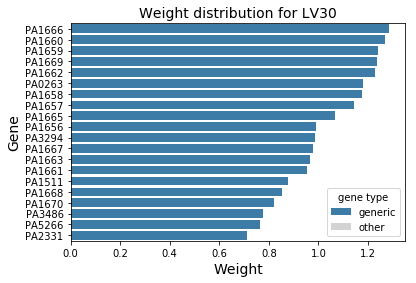

In [28]:
# Plot distribution of weights for these nodes
node = "LV30"
lv.plot_dist_weights(
    node,
    multiplier_model_z,
    shared_genes,
    20,
    all_coverage_df,
    f"weight_dist_{node}.svg",
)

## Save

In [29]:
# Save plot
nonzero_fig.figure.savefig(
    nonzero_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

# Save plot
highweight_fig.figure.savefig(
    highweight_figure_filename,
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
    dpi=300,
)

**Takeaway:**
* In the first nonzero boxplot, generic and other genes are present in a similar number of LVs. This isn't surprising since the number of genes that contribute to each LV is <1000.
* In the second highweight boxplot, other genes and generic genes are highly weighted in a similar number of LVs, but overall generic genes contribute a lot to very few LVs. The only associated LV is related to type IV secretion system, which is a complex responsible for a broad range of functions: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070162/

Compared to the trend found using [human data](1_get_multiplier_LV_coverage.ipynb), perhaps this indicates that generic genes have similar behavior/roles across organisms.